In [12]:
import os, json
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

warnings.filterwarnings('ignore')

In [32]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_selection import SelectPercentile, SelectFromModel, RFE, f_regression

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
config_file = "config.json"

with open(config_file, "r") as f:
    config = json.load(f)

In [4]:
data = np.loadtxt(os.path.join(config["data_path"], config["data_file"]), delimiter=",", dtype=np.float32)

In [5]:
def find_best_n_features_by_percentile(estimator, train_x, train_y, test_x, test_y):
    n_features = []
    scores = []
    selects = []
    for i in range(0, 100):        
        select = SelectPercentile(score_func=f_regression, percentile=i + 1)
        select.fit(train_x, train_y)
        select_x = select.transform(train_x)
        estimator.fit(select_x, train_y)
        selects.append(select)
        n_features.append(select_x.shape[1])
        scores.append(estimator.score(select.transform(test_x), test_y))
    return np.array(n_features), np.array(scores), selects[np.argmax(np.array(scores))]

In [6]:
def find_best_n_features_from_model(estimator, train_x, train_y, test_x, test_y):    
    n_features = []
    scores = []
    selects = []
    for threshold in ("median", "1.2*median", "1.4*median", "mean", "1.2*mean", "1.4*mean", "10*mean"):
        select = SelectFromModel(estimator, threshold=threshold)
        select.fit(train_x, train_y)
        select_x = select.transform(train_x)
        estimator.fit(select_x, train_y)
        selects.append(select)
        n_features.append(select_x.shape[1])
        scores.append(estimator.score(select.transform(test_x), test_y))
    return np.array(n_features), np.array(scores), selects[np.argmax(np.array(scores))]

In [7]:
def find_best_n_features_from_RFE(estimator, train_x, train_y, test_x, test_y):    
    n_features = []
    scores = []
    selects = []
    for i in range(0, train_x.shape[1]):
        select = RFE(estimator, n_features_to_select=i + 1)
        select.fit(train_x, train_y)
        select_x = select.transform(train_x)
        estimator.fit(select_x, train_y)
        selects.append(select)
        n_features.append(select_x.shape[1])
        scores.append(estimator.score(select.transform(test_x), test_y))
    return np.array(n_features), np.array(scores), selects[np.argmax(np.array(scores))]

### 1. 피처 엔지니어링

In [8]:
x = data[:, :-1]
y = data[:, 13]

In [9]:
train_x, test_x, train_y, test_y = train_test_split(x,  y, test_size=0.2, random_state=1)

#### LinaerRegression

In [10]:
lr = LinearRegression()

In [13]:
res = cross_validate(lr, train_x, train_y, cv=5, return_train_score=True)
res = pd.DataFrame(res)

In [14]:
print(res)
print()
print(res.mean(axis=0))

   fit_time  score_time  test_score  train_score
0  0.001889    0.000866    0.753503     0.720783
1  0.001338    0.000666    0.692025     0.735760
2  0.000871    0.000651    0.682255     0.730841
3  0.000864    0.000644    0.669012     0.742178
4  0.000863    0.000675    0.715768     0.730887

fit_time       0.001165
score_time     0.000700
test_score     0.702512
train_score    0.732090
dtype: float64


In [15]:
def getPolynomialFeatures(x, degree=2):
    polynomial_features = PolynomialFeatures(degree=degree)
    x_poly = polynomial_features.fit_transform(x)
    return x_poly, polynomial_features

In [16]:
def make_features(data, transform_method=None, degree=None):        
    x = data[:, :-1]
    y = data[:, 13]
    
    if transform_method == 'Standard':
        sc = StandardScaler()
        sc.fit(x)
        x = sc.transform(x)
    elif transform_method == 'MinMax':
        mmsc = MinMaxScaler()
        mmsc.fit(x)
        x = mmsc.transform(x)
    
    if transform_method == 'Log':
        x = np.log1p(x)        
    
    polynomial_feaures = None
    
    if degree != None:
        x, polynomial_feaures = getPolynomialFeatures(x, degree)
    
    train_x, test_x, train_y, test_y = train_test_split(x,  y, test_size=0.2, random_state=1)    
    
    return train_x, test_x, train_y, test_y, polynomial_feaures

In [17]:
lr.fit(train_x, train_y)
print(lr.score(train_x, train_y))
print(lr.score(test_x, test_y))

0.7293585250219268
0.7634163924072883


In [18]:
train_x, test_x, train_y, test_y, polynomial_feaures = make_features(data, transform_method='Standard', degree=2)

In [19]:
lr.fit(train_x, train_y)
print(lr.score(train_x, train_y))
print(lr.score(test_x, test_y))

0.9264046779853473
0.9116246116297384


In [22]:
def train_features(estimator, train_x, train_y, cv=5):    
    return cross_validate(estimator, train_x, train_y, cv=cv, return_train_score=True)

In [23]:
pd.DataFrame(train_features(lr, train_x, train_y)).mean()

fit_time       0.011601
score_time     0.000806
test_score     0.749104
train_score    0.933484
dtype: float64

In [24]:
params = []

params.append(['Original', None, None])
params.append(['Original + Poly 2', None, 2])
params.append(['Original + Poly 3', None, 3])
params.append(['StandardScaler', 'Standard', None])
params.append(['StandardScaler + Poly 2', 'Standard', 2])
params.append(['StandardScaler + Poly 3', 'Standard', 3])
params.append(['MinMaxScaler', 'MinMax', None])
params.append(['MinMaxScaler + Poly 2', 'MinMax', 2])
params.append(['MinMaxScaler + Poly 3', 'MinMax', 3])
params.append(['Log', 'Log', None])
params.append(['Log + Poly 2', 'Log', 2])
params.append(['Log + Poly 3', 'Log', 3])

In [25]:
results = []

for param in params:
    train_x, test_x, train_y, test_y, _ = make_features(data, transform_method=param[1], degree=param[2])    
    res = pd.DataFrame(train_features(LinearRegression(), train_x, train_y)).mean()
    results.append([param[0], res[0], res[1], res[2], res[3]])

In [26]:
res = pd.DataFrame(results)
res.columns = ['feature', 'mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score']
res.sort_values('mean_test_score', ascending=False)

,feature,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
9,Log,0.000591,0.000469,0.750569,0.778385
7,MinMaxScaler + Poly 2,0.005606,0.000521,0.749235,0.934059
4,StandardScaler + Poly 2,0.005457,0.000526,0.749104,0.933484
0,Original,0.001214,0.000826,0.702512,0.732090
6,MinMaxScaler,0.000591,0.000460,0.702512,0.732090
3,StandardScaler,0.000597,0.000481,0.702512,0.732090
1,Original + Poly 2,0.008579,0.000665,0.692269,0.911356
10,Log + Poly 2,0.005311,0.000526,0.631707,0.842505
2,Original + Poly 3,0.035240,0.000611,-0.386780,0.962820
8,MinMaxScaler + Poly 3,0.035452,0.000590,-30.467472,0.999852


In [28]:
train_x, test_x, train_y, test_y, polynomial_features = make_features(data, transform_method='Log', degree=None)

In [33]:
n_features, scores, select = find_best_n_features_by_percentile(LinearRegression(), train_x, train_y, test_x, test_y)
print('n_features: {}'.format(n_features[np.argmax(scores)]))
print('best_score: {}'.format(np.max(scores)))

n_features: 13
best_score: 0.8261641691260689


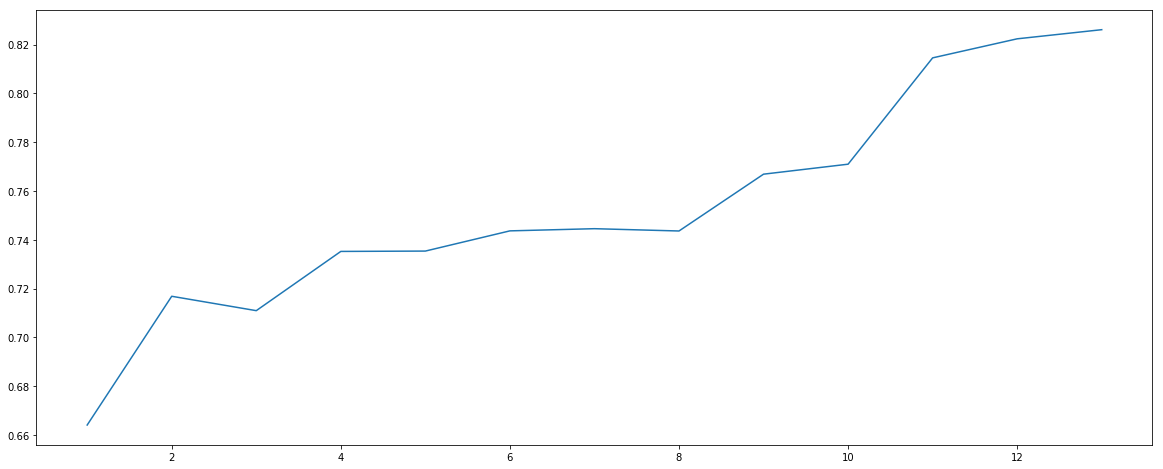

In [34]:
plt.figure(figsize=(20, 8))
plt.plot(n_features, scores)

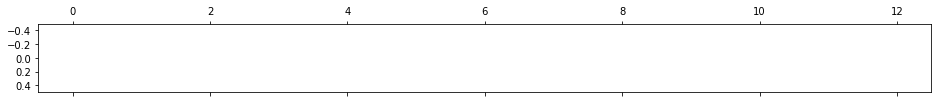

In [35]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [37]:
n_features, scores, select = find_best_n_features_from_RFE(LinearRegression(), train_x, train_y, test_x, test_y)
print('n_features: {}'.format(n_features[np.argmax(scores)]))
print('best_score: {}'.format(np.max(scores)))

n_features: 11
best_score: 0.8269428782685562


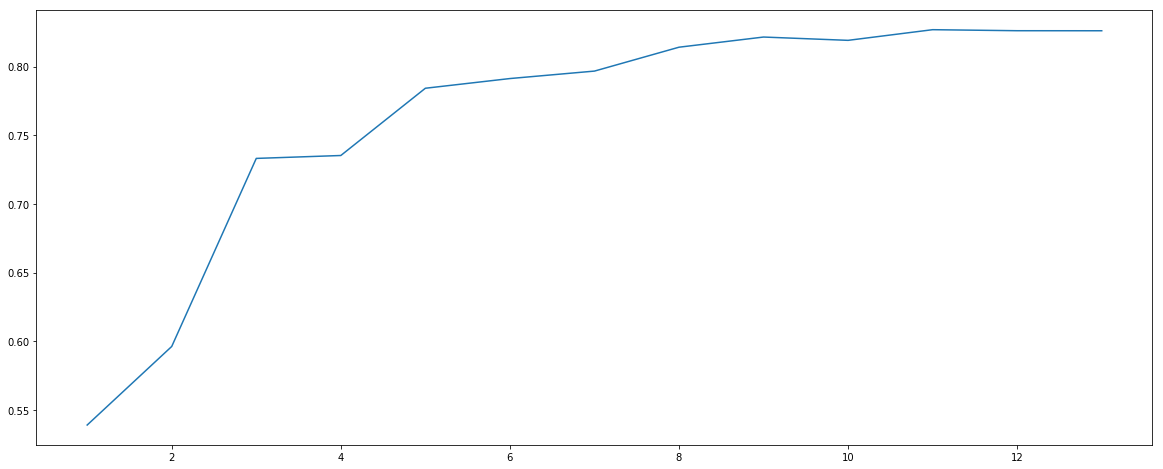

In [38]:
plt.figure(figsize=(20, 8))
plt.plot(n_features, scores)

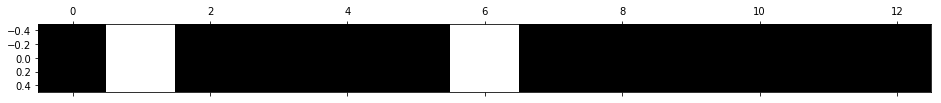

In [39]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [40]:
n_features, scores, select = find_best_n_features_from_RFE(LinearRegression(), train_x, train_y, test_x, test_y)
print('n_features: {}'.format(n_features[np.argmax(scores)]))
print('best_score: {}'.format(np.max(scores)))

n_features: 11
best_score: 0.8269428782685562


In [41]:
lm_feature_selection = select.get_support()

#### RandomForest

In [42]:
results = []

for param in params:
    train_x, test_x, train_y, test_y, _ = make_features(data, transform_method=param[1], degree=param[2])    
    res = pd.DataFrame(train_features(RandomForestRegressor(n_estimators=300), train_x, train_y)).mean()
    results.append([param[0], res[0], res[1], res[2], res[3]])

In [43]:
res = pd.DataFrame(results)
res.columns = ['feature', 'mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score']
res.sort_values('mean_test_score', ascending=False)

,feature,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
7,MinMaxScaler + Poly 2,1.850325,0.008071,0.870091,0.981152
11,Log + Poly 3,8.545906,0.008665,0.867307,0.979732
3,StandardScaler,0.334932,0.008017,0.867085,0.980568
9,Log,0.334733,0.008063,0.866883,0.981070
0,Original,0.340501,0.008143,0.864145,0.979685
6,MinMaxScaler,0.334297,0.008086,0.863999,0.979864
10,Log + Poly 2,1.852090,0.008099,0.862343,0.980074
1,Original + Poly 2,1.869377,0.008134,0.851708,0.978886
2,Original + Poly 3,8.492397,0.008461,0.846152,0.979026
8,MinMaxScaler + Poly 3,8.600174,0.008391,0.841821,0.978931


In [44]:
train_x, test_x, train_y, test_y, _ = make_features(data, transform_method=None, degree=None)

In [45]:
rf = RandomForestRegressor(n_estimators=300)
rf.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [46]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM' ,'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
feature_impotances = pd.Series(rf.feature_importances_, index=feature_names)
feature_impotances = feature_impotances.sort_values(ascending=False)

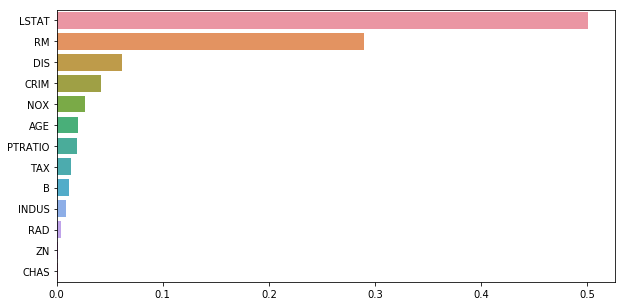

In [47]:
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_impotances, y=feature_impotances.index)

In [48]:
n_features, scores, select = find_best_n_features_by_percentile(RandomForestRegressor(n_estimators=300), train_x, train_y, test_x, test_y)
print('n_features: {}'.format(n_features[np.argmax(scores)]))
print('best_score: {}'.format(np.max(scores)))

n_features: 12
best_score: 0.9152074992392787


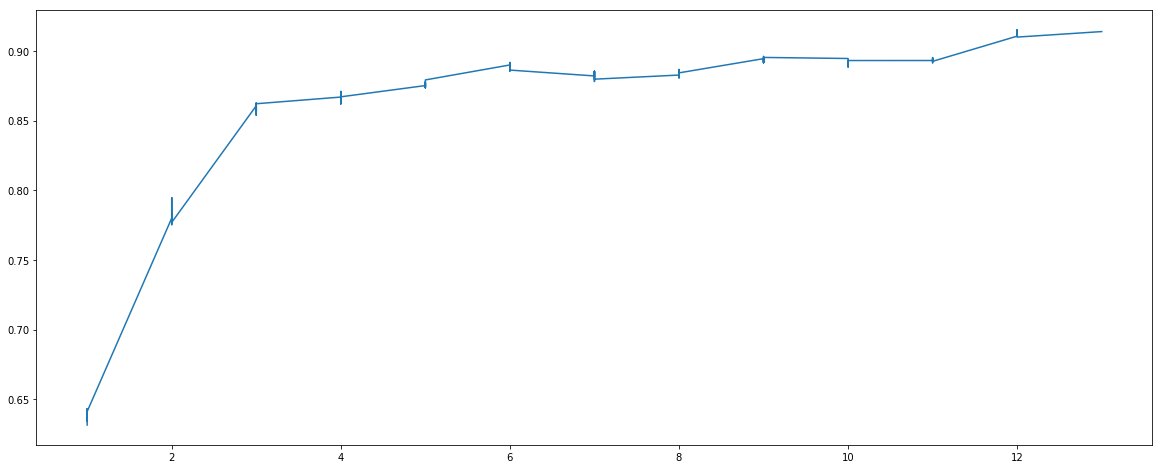

In [49]:
plt.figure(figsize=(20, 8))
plt.plot(n_features, scores)

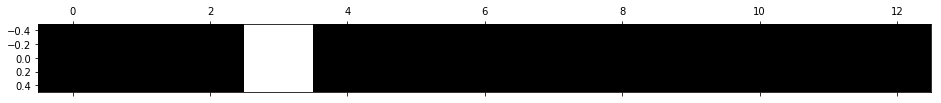

In [50]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [656]:
n_features, scores, select = find_best_n_features_from_RFE(RandomForestRegressor(n_estimators=300), train_x, train_y, test_x, test_y)
print('n_features: {}'.format(n_features[np.argmax(scores)]))
print('best_score: {}'.format(np.max(scores)))

n_features: 8
best_score: 0.9152180980473656


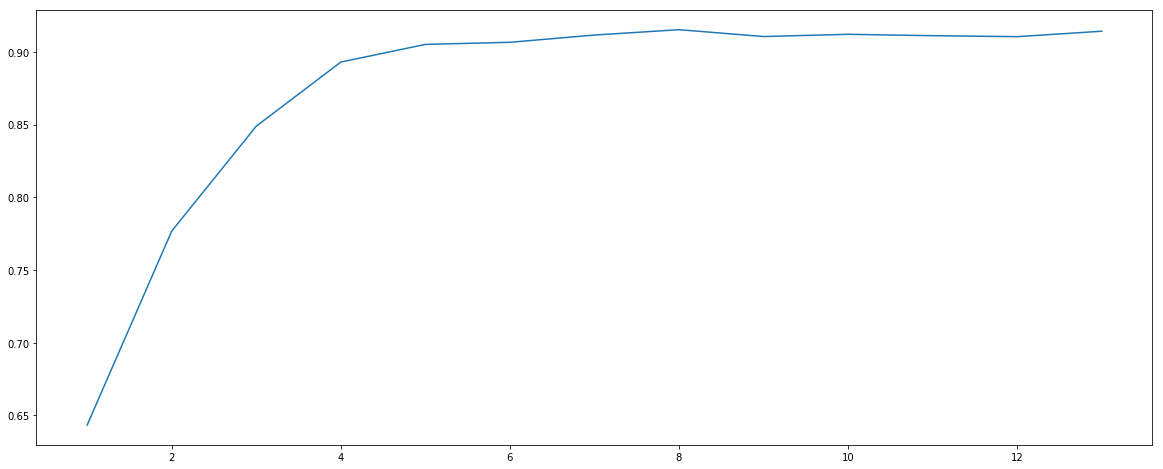

In [657]:
plt.figure(figsize=(20, 8))
plt.plot(n_features, scores)

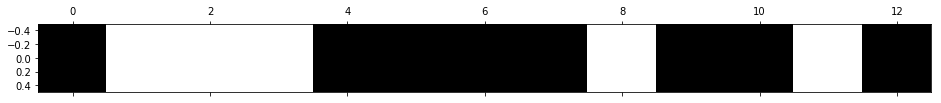

In [658]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

### 2. 모델링

In [51]:
train_x, test_x, train_y, test_y, _ = make_features(data, transform_method='MinMax', degree=2)

In [52]:
models = []

In [53]:
def train_models(estimator, param_grid, train_x, train_y, test_x, test_y):
    cv = GridSearchCV(estimator, param_grid=param_grid, scoring='r2', cv=10, n_jobs=-1, return_train_score=True)
    cv.fit(train_x, train_y)
    cv.best_estimator_.score(test_x, test_y)
    return [estimator.__class__, cv.best_estimator_, cv.best_params_, cv.best_score_, cv.best_estimator_.score(test_x, test_y), cv]   

#### Lasso

In [54]:
lasso_params = [
    { 'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0] }
]

In [55]:
models.append(train_models(Lasso(), lasso_params, train_x, train_y, test_x, test_y))

#### Ridge

In [56]:
ridge_params = [
    { 'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0] }
]

In [57]:
models.append(train_models(Ridge(), ridge_params, train_x, train_y, test_x, test_y))

#### RandomForest

In [58]:
rf_params = [
    {
        'n_estimators': [100, 200, 300, 500, 1000],
        'max_depth': [2, 4, 6, 8, 10, 15, 20]
    }
]

In [59]:
models.append(train_models(RandomForestRegressor(), rf_params, train_x, train_y, test_x, test_y))

#### Gridient Boosting

In [60]:
gb_grid = [
    {
        'learning_rate': [0.001, 0.01, 0.1],
        'max_depth': [2, 4, 6, 8, 10, 15, 20],
        'n_estimators': [100, 200, 300, 500, 1000]
    }
]

In [61]:
models.append(train_models(GradientBoostingRegressor(), gb_grid, train_x, train_y, test_x, test_y))

#### LightGBM

In [62]:
lgbm_params = [
    {
        'learning_rate': [0.001, 0.01, 0.1],
        'max_depth': [2, 4, 6, 8, 10, 15, 20],
        'n_estimators': [100, 200, 300, 500, 1000]
    }
]

In [63]:
models.append(train_models(LGBMRegressor(), lgbm_params, train_x, train_y, test_x, test_y))

#### XGBoost

In [64]:
xgb_params = [
    {
        'learning_rate': [0.001, 0.01, 0.1],
        'max_depth': [2, 4, 6, 8, 10, 15, 20],
        'n_estimators': [100, 200, 300, 500, 1000]
    }
]

In [65]:
models.append(train_models(XGBRegressor(), xgb_params, train_x, train_y, test_x, test_y))

[00:40:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### 3. 평가

In [66]:
eval_df = pd.DataFrame(models)
eval_df.columns = ['class', 'estimator', 'best_params', 'valid_r2_score', 'test_r2_score', 'cv']

In [67]:
eval_df

,class,estimator,best_params,valid_r2_score,test_r2_score,cv
0,<class 'sklearn.linear_model.coordinate_descen...,"Lasso(alpha=0.001, copy_X=True, fit_intercept=...",{'alpha': 0.001},0.801090,0.918163,"GridSearchCV(cv=10, error_score='raise-depreca..."
1,<class 'sklearn.linear_model.ridge.Ridge'>,"Ridge(alpha=0.1, copy_X=True, fit_intercept=Tr...",{'alpha': 0.1},0.807664,0.925851,"GridSearchCV(cv=10, error_score='raise-depreca..."
2,<class 'sklearn.ensemble.forest.RandomForestRe...,"(DecisionTreeRegressor(criterion='mse', max_de...","{'max_depth': 15, 'n_estimators': 200}",0.874483,0.919734,"GridSearchCV(cv=10, error_score='raise-depreca..."
3,<class 'sklearn.ensemble.gradient_boosting.Gra...,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.890904,0.907317,"GridSearchCV(cv=10, error_score='raise-depreca..."
4,<class 'lightgbm.sklearn.LGBMRegressor'>,"LGBMRegressor(boosting_type='gbdt', class_weig...","{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.881213,0.905779,"GridSearchCV(cv=10, error_score='raise-depreca..."
5,<class 'xgboost.sklearn.XGBRegressor'>,"XGBRegressor(base_score=0.5, booster='gbtree',...","{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.900582,0.903337,"GridSearchCV(cv=10, error_score='raise-depreca..."


In [68]:
corr_df = pd.DataFrame(test_y)
for model in models:
    corr_df = pd.concat([corr_df, pd.DataFrame(model[1].predict(test_x))], axis=1)

In [69]:
corr_df.columns = ['real', 'lasso', 'ridge', 'randomforest', 'gradientboosting', 'lightgbm', 'xgboost']

In [70]:
corr_df.corr()['real'].sort_values(ascending=False)

real                1.000000
ridge               0.965693
randomforest        0.964419
lasso               0.959832
gradientboosting    0.955868
lightgbm            0.953941
xgboost             0.952658
Name: real, dtype: float64

In [71]:
corr_df['rr_ensemble'] = corr_df['ridge'] * 0.4 + corr_df['randomforest'] * 0.6

In [72]:
corr_df.corr()['real'].sort_values(ascending=False)

real                1.000000
rr_ensemble         0.972201
ridge               0.965693
randomforest        0.964419
lasso               0.959832
gradientboosting    0.955868
lightgbm            0.953941
xgboost             0.952658
Name: real, dtype: float64

In [73]:
n_features, scores, select = find_best_n_features_from_RFE(models[1][1], train_x, train_y, test_x, test_y)
print('n_features: {}'.format(n_features[np.argmax(scores)]))
print('best_score: {}'.format(np.max(scores)))

n_features: 91
best_score: 0.9259689079680443


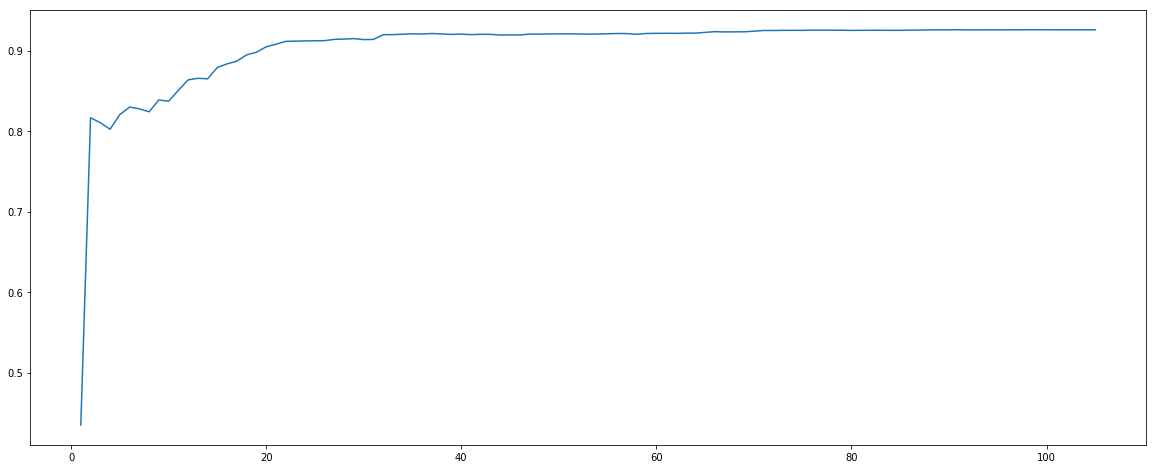

In [74]:
plt.figure(figsize=(20, 8))
plt.plot(n_features, scores)